#  **1-Data Preparation**

## 1.1 - Selection of Sectors

The three sectors took for analysis is:

    A --  Consumer Staples
    B -- Industrials
    C -- Utilities

In each of the three sectors, we chose all the stocks from the [List of S&P 500 companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)

## 1.2 - Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=e91b8f7722715b5cd812ca25f453e708cd744b1fce83de85e643bb9a88c22b55
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [3]:
# Install Pyomo
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 138MB/s]


In [4]:
%%capture
!pip install numpy pandas matplotlib pyomo

In [5]:
%%capture
import sys
import os


if 'google.colab' in sys.modules:
   !pip install idaes-pse --pre
   !idaes get-extensions --to ./bin
   os.environ['PATH'] += ':bin'


# import modules


%matplotlib inline
from pylab import *


import shutil
import sys
import os.path
from pyomo.environ import *


executable = '/content/bin/bonmin' # THIS IS NEW! We are using the IPOPT Solver.

## 1.3 - Selection & Retrieval of Stocks data

In [6]:
# Fetch S&P 500 tickers and sectors
sp500_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_table = sp500_data[0]
tickers_500 = sp500_table[['Symbol', 'GICS Sector']]


## 1.4 - Retrieving Historical Data for All tickers

In [7]:
# Define sectors of interest
sectors_of_interest = ['Consumer Staples', 'Industrials', 'Utilities']

# Filter tickers based on sectors of interest
filtered_tickers = tickers_500[tickers_500['GICS Sector'].isin(sectors_of_interest)]
tickers_list = filtered_tickers['Symbol'].tolist()

# Define date range
start_date = '2017-01-01'
end_date = '2022-12-31'

# Initialize dictionary to store historical prices
sector_historical = {}
failed_tickers = []

# Retrieve historical data for each ticker
for ticker in tickers_list:
    try:
        sector_historical[ticker] = si.get_data(ticker, start_date=start_date, end_date=end_date, interval="1d")
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        failed_tickers.append(ticker)

print("\nTickers with retrieval errors:", failed_tickers)


Error retrieving data for BF.B: 'timestamp'
Error retrieving data for GEV: {'chart': {'result': None, 'error': {'code': 'Bad Request', 'description': "Data doesn't exist for startDate = 1483228800, endDate = 1672444800"}}}
Error retrieving data for KVUE: {'chart': {'result': None, 'error': {'code': 'Bad Request', 'description': "Data doesn't exist for startDate = 1483228800, endDate = 1672444800"}}}
Error retrieving data for VLTO: {'chart': {'result': None, 'error': {'code': 'Bad Request', 'description': "Data doesn't exist for startDate = 1483228800, endDate = 1672444800"}}}

Tickers with retrieval errors: ['BF.B', 'GEV', 'KVUE', 'VLTO']


The Below Tickers have the insufficient historical data. So, the stocks data has been excluded for these tickers.


*   BF.B
*   GEV
*   KVUE
*   VLTO

In [8]:
# To get an understanding of the imported data
# sector_historical

In [9]:
# Extract only the data we need (adjclose)
def extract_adj_close_for_sector(sector_historical, sector_of_interest, tickers_500):
    sector_adj_close = pd.DataFrame()

    # Iterate over the keys (symbols) in sector_historical
    for symbol, data in sector_historical.items():
        # If the symbol belongs to the specified sector, extract the 'Adj Close' data
        if symbol in tickers_500[tickers_500['GICS Sector'] == sector_of_interest]['Symbol'].tolist():
            sector_adj_close[symbol] = data['adjclose']

    return sector_adj_close


In [10]:
consumer_staple_df = extract_adj_close_for_sector(sector_historical, 'Consumer Staples', tickers_500)
industrial_df = extract_adj_close_for_sector(sector_historical, 'Industrials', tickers_500)
utility_df = extract_adj_close_for_sector(sector_historical, 'Utilities', tickers_500)

In [11]:
# shape of sector dataframes before removing the null values
print(consumer_staple_df.shape)
print(industrial_df.shape)
print(utility_df.shape)

(1510, 36)
(1510, 77)
(1510, 30)


In [12]:
# consumer_staple_df

In [13]:
# industrial_df

In [14]:
# utility_df

In [15]:
# Drop any na records
consumer_staple_df = consumer_staple_df.dropna(how='all',axis=1)
industrial_df = industrial_df.dropna(how='all',axis=1)
utility_df  = utility_df.dropna(how='all',axis=1)

In [16]:
# shape of sector dataframes after removing the null values
print(consumer_staple_df.shape)
print(consumer_staple_df.shape)
print(industrial_df.shape)
print(utility_df.shape)

(1510, 36)
(1510, 36)
(1510, 77)
(1510, 30)


In [17]:
# Check to make sure there are no remaining null values
print(consumer_staple_df.info())
print(industrial_df.info())
print(utility_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 to 2022-12-30
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MO      1510 non-null   float64
 1   ADM     1510 non-null   float64
 2   BG      1510 non-null   float64
 3   CPB     1510 non-null   float64
 4   CHD     1510 non-null   float64
 5   CLX     1510 non-null   float64
 6   KO      1510 non-null   float64
 7   CL      1510 non-null   float64
 8   CAG     1510 non-null   float64
 9   STZ     1510 non-null   float64
 10  COST    1510 non-null   float64
 11  DG      1510 non-null   float64
 12  DLTR    1510 non-null   float64
 13  EL      1510 non-null   float64
 14  GIS     1510 non-null   float64
 15  HSY     1510 non-null   float64
 16  HRL     1510 non-null   float64
 17  K       1510 non-null   float64
 18  KDP     1510 non-null   float64
 19  KMB     1510 non-null   float64
 20  KHC     1510 non-null   float64
 21  KR      1510 non-nu

## 1.5 -  Linear Regression


To prepare the dataset for each stock using the common trading days for the years 2017 - 2021, we need to calculate the performance ratios c/p1, c/p2, c/p3, where:


*  *p1*  is the stock price at the end of 2019.
*  *p2*  is the price at the end of 2018.
*  *p3*  is the price at the end of 2017.
*  *c*   is the price at the end of 2020.
*  Additionally, we need to calculate the target, *f/c*, where *f*  is the price at the end of 2021.

In [21]:
import pandas as pd
import numpy as np

def transform_data_for_regression(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the input DataFrame into a format suitable for linear regression analysis.

    :param df: Input DataFrame containing financial data.
    :return: Transposed DataFrame with ratios for each stock.
    """
    # Reset the index and rename the 'index' column to 'Date'
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)

    # Create a transpose DataFrame with stock names as rows
    transpose_df = pd.DataFrame(df.columns[1:], columns=['Stocks'])

    # Define the specific dates for retrieving values
    dates = {
        'p1': '2020-12-31',
        'p2': '2019-12-31',
        'p3': '2018-12-31',
        'c': '2021-12-31',
        'f': ['2022-12-31', '2022-12-30']  # Try these dates for 'f' value
    }

    # Initialize columns for ratios
    transpose_df['c/p1'] = np.nan
    transpose_df['c/p2'] = np.nan
    transpose_df['c/p3'] = np.nan
    transpose_df['f/c'] = np.nan

    # Loop through each stock
    for i, stock in enumerate(transpose_df['Stocks']):
        # Get the closing prices for specific dates
        p1 = df.loc[df['Date'] == dates['p1'], stock].values
        p2 = df.loc[df['Date'] == dates['p2'], stock].values
        p3 = df.loc[df['Date'] == dates['p3'], stock].values
        c = df.loc[df['Date'] == dates['c'], stock].values

        # Get the F value
        f = df.loc[df['Date'].isin(dates['f']), stock].values
        if np.isnan(f).any():
            f = df.loc[df['Date'] == '2022-12-30', stock].values
        if not f.size:
            f = df.loc[df['Date'] == '2022-12-30', stock].values

        # Calculate and assign the ratios
        transpose_df.loc[i, 'c/p1'] = c / p1
        transpose_df.loc[i, 'c/p2'] = c / p2
        transpose_df.loc[i, 'c/p3'] = c / p3
        transpose_df.loc[i, 'f/c'] = f / c

    return transpose_df


The above function transforms a DataFrame for linear regression. It rearranges the data to have stocks as rows and computes ratios like current price to past prices (c/p1, c/p2, c/p3), and future price to current price (f/c).

The output DataFrame is ready for linear regression analysis.

In [22]:
final_consumer_staple_df = transform_data_for_regression(consumer_staple_df)

In [23]:
final_industrial_df = transform_data_for_regression(industrial_df)

In [24]:
final_utility_df = transform_data_for_regression(utility_df)

In [25]:
# final_consumer_staple_df

In [26]:
# final_utility_df

In [27]:
# final_industrial_df

In [28]:
# filling the null values with 0 which we got in transformed dataframes
final_utility_df = final_utility_df.fillna(0)
final_industrial_df=final_industrial_df.fillna(0)

In [29]:
def fit_the_model(df:pd.DataFrame):
  """
  This function will fit the  Linear Regresion model for a given dataframe using pyomo and returns the values or parameters in a list which are obtained after fitting the model
  """
  #Declaring the trainable parameters and convert them to list
  Z = df['f/c'].to_list()
  W = df['c/p3'].to_list()
  X = df['c/p2'].to_list()
  Y = df['c/p1'].to_list()

  # declare the model
  model = ConcreteModel()
  n_points = len(X)
  # declare decision variables
  model.a = Var(domain=Reals,initialize = 1)
  model.b = Var(domain=Reals, initialize = 1)
  model.c = Var(domain = Reals, initialize = 1)
  model.d = Var(domain = Reals, initialize = 1)
  model.z = Var([i for i in range(n_points)],domain=Reals)
  # Constraints
  model.constraints = ConstraintList()
  # Predicted value
  for i in range(n_points):
    w = W[i]
    x = X[i]
    y = Y[i]
    model.constraints.add(model.z[i] == model.a + w*model.b + x*model.c + y*model.d )

  # declare objective
  obj_expr = 0
  for i in range(n_points):
    obj_expr += (model.z[i] - Z[i])**2
  model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)
  # solve it
  SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()

  # Return the values for the model
  return [model.a(),model.b(),model.c(),model.d()]

In [30]:
def predict_values(df:pd.DataFrame,predictors:list):
  """
  This function will predict using the model parameters and returns the top three stocks based on the predictions
  """

  # Let us unpack the list to the model parameters
  a,b,c,d = predictors

  # We have to create a column seperately for predictions (to be precise it is the stocks for 2023)
  df['predictions_2022'] = a + df['c/p2']*b + c*df['c/p1']+d*df['f/c']

  # Since we got the predictions let us sort the dataframe on predictions_2023 column on descending order
  sorted_df = df.sort_values(by='predictions_2022',ascending=False)

  return sorted_df.head(3)

In [31]:
consumer_staple_top = predict_values(final_consumer_staple_df,fit_the_model(final_consumer_staple_df))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 36
  Number of variables: 40
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.01304769515991211
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [32]:
utility_top = predict_values(final_utility_df,fit_the_model(final_utility_df))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 30
  Number of variables: 34
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.013614177703857422
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [33]:
industrial_top = predict_values(final_industrial_df,fit_the_model(final_industrial_df))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 77
  Number of variables: 81
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.01997661590576172
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


## 1.6 -  Top 3 stocks from Linear Regression

In [34]:
consumer_staple_top

,Stocks,c/p1,c/p2,c/p3,f/c,predictions_2022
33,TSN,1.384724,1.006069,1.749641,0.731015,1.232997
34,WBA,1.357875,0.959020,0.853604,0.749396,1.231508
13,EL,1.400350,1.817292,2.913921,0.676874,1.155029


In [35]:
utility_top

,Stocks,c/p1,c/p2,c/p3,f/c,predictions_2022
22,PCG,0.974318,1.116835,0.511158,1.339374,1.131383
26,SRE,1.073875,0.936623,1.348812,1.202993,1.108606
18,FE,1.418051,0.933334,1.251896,1.047870,1.107880


In [36]:
industrial_top

,Stocks,c/p1,c/p2,c/p3,f/c,predictions_2022
42,LDOS,0.858035,0.934868,1.765247,1.200448,0.968120
67,UBER,0.822157,1.409886,0.000000,0.589792,0.967863
62,LUV,0.919116,0.796682,0.937867,0.785948,0.967234


## 1.6 Visualizing the Time Series of top 3 slots from Regression

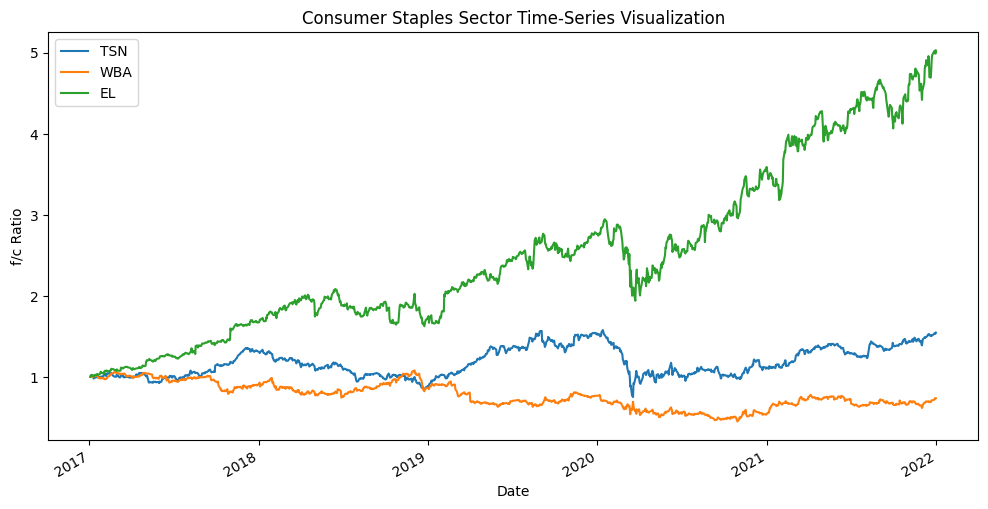

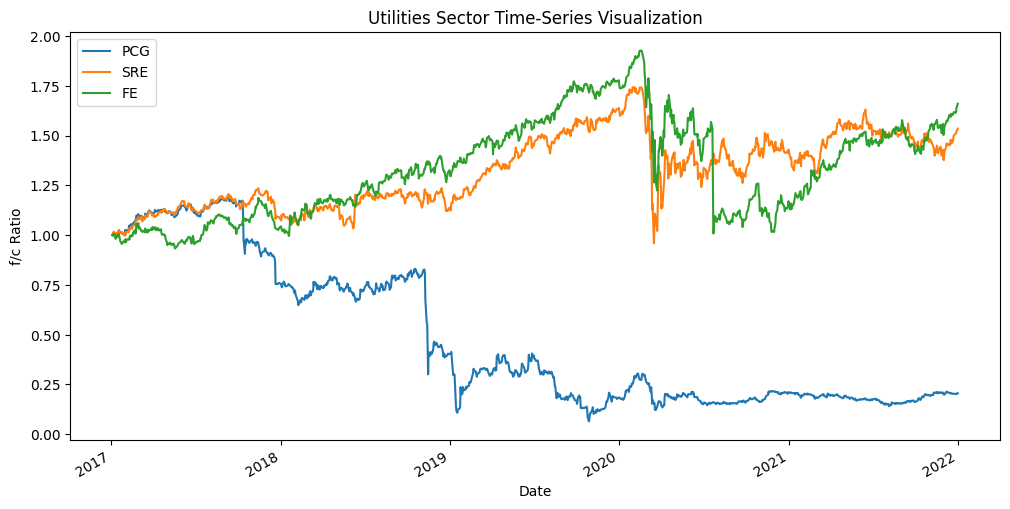

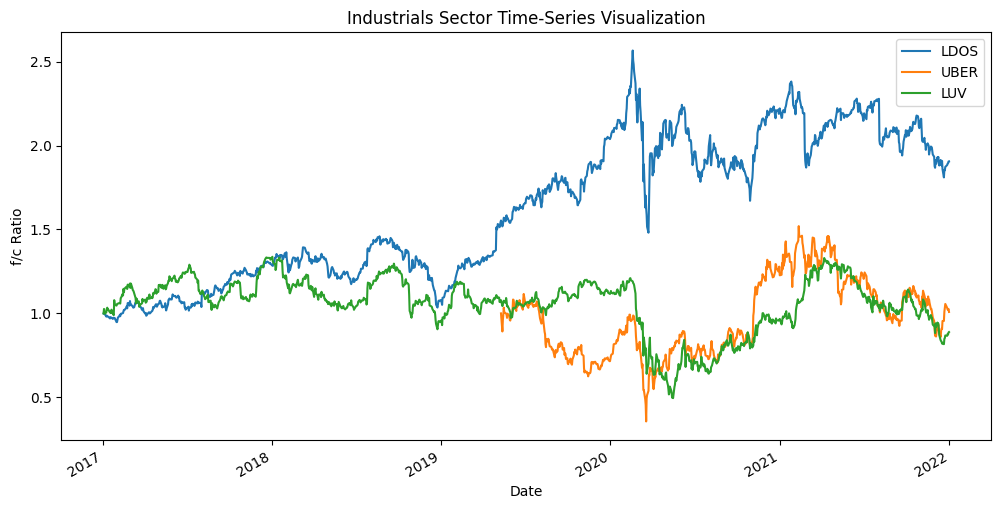

In [41]:

# Function to generate time-series visualization for a sector
def plot_sector_timeseries(sector_historical, top_df, sector_name):
    fig, ax = plt.subplots(figsize=(12, 6))

    for ticker in top_df['Stocks'].tolist():
        if ticker in sector_historical:
            sector_historical[ticker]['c'] = sector_historical[ticker]['adjclose'].iloc[0]
            sector_historical[ticker]['f/c'] = sector_historical[ticker]['adjclose'] / sector_historical[ticker]['c']
            sector_historical[ticker]['f/c'].loc['2017-01-01':'2021-12-31'].plot(ax=ax, label=ticker)

    ax.set_title(f"{sector_name} Sector Time-Series Visualization")
    ax.set_xlabel("Date")
    ax.set_ylabel("f/c Ratio")
    ax.legend()
    plt.show()

# Generate time-series visualizations for each sector
plot_sector_timeseries(sector_historical, consumer_staple_top, 'Consumer Staples')
plot_sector_timeseries(sector_historical, utility_top, 'Utilities')
plot_sector_timeseries(sector_historical, industrial_top, 'Industrials')



Top performing stocks from all the 3  Sectors:


1.   Consumer Staples - EL
2.   Utilities   - FE
3.   Industrials - LDOS

# **2-Modern Portfolio Theory**


Steps we perform in below:

*  Compute the daily returns for the 9 chosen stocks.
*   Calculate the average yearly returns and the standard deviation of these returns to gauge their risk and return characteristics.
*   Construct the covariance matrix and correlation for these stocks to evaluate their interrelated movements.







In [44]:
finalized_tickers_list = ['TSN', 'WBA', 'EL', 'LDOS', 'UBER', 'LUV', 'PCG', 'SRE', 'FE']

In [45]:
import yfinance as yf

# Define date range
start_date = '2017-01-01'
end_date = '2021-12-31'

# Initialize dictionary to store historical prices
historical_prices = {}
failed_tick = []

# Retrieve historical data for each ticker
for ticker in finalized_tickers_list:
    try:
        # sector_hist[ticker] = si.get_data(ticker, start_date=start_date, end_date=end_date, interval="1d")
        data = yf.download(ticker, start=start_date, end=end_date,interval='1d')
        if not data.empty:
            historical_prices[ticker] = data['Adj Close']
        else:
            date_range = pd.date_range(start=start_date, end=end_date)
            historical_prices[ticker] = pd.Series(index=date_range, dtype=float)
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        failed_tickers.append(ticker)


print("\nTickers with retrieval errors:", failed_tick)

# Convert the dictionary to DataFrame
histry_prices_df = pd.DataFrame(historical_prices)

print(histry_prices_df)
histry_prices_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tickers with retrieval errors: []
                  TSN        WBA          EL       LDOS       UBER        LUV  \
Date                                                                            
2017-01-03  52.648819  62.632915   71.487518  45.140743        NaN  46.634418   
2017-01-04  53.397583  62.647999   72.753990  45.495129        NaN  47.866055   
2017-01-05  53.675205  62.685738   72.661568  44.981266        NaN  47.091614   
2017-01-06  53.271374  62.738605   73.179276  44.883812        NaN  46.587757   
2017-01-09  52.707714  62.323364   72.328773  44.281334        NaN  46.932991   
...               ...        ...         ...        ...        ...        ...   
2021-12-23  79.545128  44.505135  355.215332  84.524651  43.910000  40.514397   
2021-12-27  80.422523  44.725544  358.398773  85.027832  42.959999  40.407955   
2021-12-28  80.898567  45.342693  356.972076  85.405235  42.540001  40.920799   
2021-12-29  80.665215  46.065639  359.184906  85.501984  42.459999  40.795

,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
Date,,,,,,,,,
2017-01-03,52.648819,62.632915,71.487518,45.140743,NaN,46.634418,58.924183,40.144436,22.870581
2017-01-04,53.397583,62.647999,72.753990,45.495129,NaN,47.866055,59.138920,40.489788,22.885353
2017-01-05,53.675205,62.685738,72.661568,44.981266,NaN,47.091614,59.090118,40.394520,22.796682
2017-01-06,53.271374,62.738605,73.179276,44.883812,NaN,46.587757,59.753830,40.854988,23.003588
2017-01-09,52.707714,62.323364,72.328773,44.281334,NaN,46.932991,58.855858,40.243679,22.914919


In [46]:
# Check if any null values
histry_prices_df.isna().sum()

TSN       0
WBA       0
EL        0
LDOS      0
UBER    591
LUV       0
PCG       0
SRE       0
FE        0
dtype: int64

In [47]:
# imputing the missing values for stock
histry_prices_df['UBER'].fillna(histry_prices_df['UBER'].mean(), inplace=True)

In [48]:
# make sure no null or missing values
histry_prices_df.isna().sum()

TSN     0
WBA     0
EL      0
LDOS    0
UBER    0
LUV     0
PCG     0
SRE     0
FE      0
dtype: int64

## 2.1 - We use percentage change (pct_change) calculation as the return metric for the finalized stocks being analyzed

In [49]:
#Taking day-over-day % change across 2018-22 for the nine stocks
return_data = pd.DataFrame()
for i in finalized_tickers_list:
  return_data[i] = histry_prices_df[i].pct_change()
# Drop the null values in the dataset
# return_data.dropna(inplace=True)
return_data

,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
Date,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.014222,0.000241,0.017716,0.007851,0.000000,0.026410,0.003644,0.008603,0.000646
2017-01-05,0.005199,0.000602,-0.001270,-0.011295,0.000000,-0.016179,-0.000825,-0.002353,-0.003875
2017-01-06,-0.007524,0.000843,0.007125,-0.002167,0.000000,-0.010699,0.011232,0.011399,0.009076
2017-01-09,-0.010581,-0.006619,-0.011622,-0.013423,0.000000,0.007410,-0.015028,-0.014963,-0.003855
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.003415,0.001389,0.011861,0.010878,0.020688,0.018239,-0.000833,0.001935,0.000247
2021-12-27,0.011030,0.004952,0.008962,0.005953,-0.021635,-0.002627,-0.007500,0.005796,-0.001974
2021-12-28,0.005919,0.013799,-0.003981,0.004439,-0.009776,0.012692,0.012595,0.004840,0.013350


## 2.2 - Mean & Stand. Deviation, Covariance & Correlation

In [50]:
# melting dataframe
Summary_stats = return_data.describe().iloc[1:3].T
Summary_stats

,mean,std
TSN,0.000513,0.018750
WBA,-0.000051,0.019837
EL,0.001442,0.018060
LDOS,0.000671,0.017771
UBER,0.000396,0.026984
LUV,0.000178,0.023396
PCG,0.000024,0.050375
SRE,0.000480,0.016803
FE,0.000566,0.018087


In [51]:
Covariance_matrix = return_data.cov()
print(Covariance_matrix)

           TSN       WBA        EL      LDOS      UBER       LUV       PCG  \
TSN   0.000352  0.000087  0.000109  0.000112  0.000180  0.000147  0.000141   
WBA   0.000087  0.000393  0.000123  0.000123  0.000067  0.000192  0.000112   
EL    0.000109  0.000123  0.000326  0.000134  0.000121  0.000164  0.000115   
LDOS  0.000112  0.000123  0.000134  0.000316  0.000124  0.000174  0.000174   
UBER  0.000180  0.000067  0.000121  0.000124  0.000728  0.000173  0.000269   
LUV   0.000147  0.000192  0.000164  0.000174  0.000173  0.000547  0.000207   
PCG   0.000141  0.000112  0.000115  0.000174  0.000269  0.000207  0.002538   
SRE   0.000105  0.000106  0.000132  0.000143  0.000104  0.000142  0.000232   
FE    0.000101  0.000104  0.000105  0.000123  0.000085  0.000110  0.000177   

           SRE        FE  
TSN   0.000105  0.000101  
WBA   0.000106  0.000104  
EL    0.000132  0.000105  
LDOS  0.000143  0.000123  
UBER  0.000104  0.000085  
LUV   0.000142  0.000110  
PCG   0.000232  0.000177  
SRE

In [52]:
Correlation_matrix = return_data.corr()
Correlation_matrix

,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
TSN,1.000000,0.234706,0.323206,0.336630,0.356042,0.334206,0.148790,0.334829,0.297692
WBA,0.234706,1.000000,0.343238,0.348002,0.125584,0.413443,0.112277,0.319523,0.289672
EL,0.323206,0.343238,1.000000,0.418365,0.248205,0.388095,0.126041,0.434413,0.321066
LDOS,0.336630,0.348002,0.418365,1.000000,0.259162,0.419324,0.194093,0.478665,0.383071
UBER,0.356042,0.125584,0.248205,0.259162,1.000000,0.274087,0.197792,0.230111,0.174579
LUV,0.334206,0.413443,0.388095,0.419324,0.274087,1.000000,0.175347,0.361286,0.261130
PCG,0.148790,0.112277,0.126041,0.194093,0.197792,0.175347,1.000000,0.273617,0.193860
SRE,0.334829,0.319523,0.434413,0.478665,0.230111,0.361286,0.273617,1.000000,0.520941
FE,0.297692,0.289672,0.321066,0.383071,0.174579,0.261130,0.193860,0.520941,1.000000


## 2.2 - Building & Executing the Model

In [53]:
m = ConcreteModel()
# defining variables for each stock
m.TSN = Var(within=NonNegativeReals, bounds=(0,1))
m.WBA = Var(within=NonNegativeReals, bounds=(0,1))
m.EL = Var(within=NonNegativeReals, bounds=(0,1))
m.LDOS = Var(within=NonNegativeReals, bounds=(0,1))
m.UBER = Var(within=NonNegativeReals, bounds=(0,1))
m.LUV = Var(within=NonNegativeReals, bounds=(0,1))
m.PCG = Var(within=NonNegativeReals, bounds=(0,1))
m.SRE = Var(within=NonNegativeReals, bounds=(0,1))
m.FE = Var(within=NonNegativeReals, bounds=(0,1))

#Activation variables
m.TSN_a = Var(domain = Binary)
m.WBA_a = Var(domain = Binary)
m.EL_a = Var(domain = Binary)
m.LDOS_a = Var(domain = Binary)
m.UBER_a = Var(domain = Binary)
m.LUV_a = Var(domain = Binary)
m.PCG_a = Var(domain = Binary)
m.SRE_a = Var(domain = Binary)
m.FE_a = Var(domain = Binary)


In [54]:
# declare objective
m.objective = Objective(expr =
                        m.TSN*Summary_stats.iloc[0,0] +
                        m.WBA*Summary_stats.iloc[1,0] +
                        m.EL*Summary_stats.iloc[2,0] +
                        m.LDOS*Summary_stats.iloc[3,0] +
                        m.UBER*Summary_stats.iloc[4,0] +
                        m.LUV*Summary_stats.iloc[5,0] +
                        m.PCG*Summary_stats.iloc[6,0] +
                        m.SRE*Summary_stats.iloc[7,0] +
                        m.FE*Summary_stats.iloc[8,0] ,
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.TSN + m.WBA + m.EL + m.LDOS + m.UBER + m.LUV + m.PCG + m.SRE + m.FE == 1)


# Set maximum risk
m.total_risk = Constraint(expr = m.TSN + m.WBA + m.EL + m.LDOS + m.UBER + m.LUV + m.PCG + m.SRE + m.FE >= 100)

#Constraints
#Allocations Constraints:
m.Constraint1 = Constraint(expr=m.TSN >=0.02*m.TSN_a)
m.Constraint2 = Constraint(expr=m.WBA >=0.02*m.WBA_a)
m.Constraint3 = Constraint(expr=m.EL >=0.02*m.EL_a)
m.Constraint4 = Constraint(expr=m.LDOS >=0.02*m.LDOS_a)
m.Constraint5 = Constraint(expr=m.UBER >=0.02*m.UBER_a)
m.Constraint6 = Constraint(expr=m.LUV >=0.02*m.LUV_a)
m.Constraint7 = Constraint(expr=m.PCG >=0.02*m.PCG_a)
m.Constraint8 = Constraint(expr=m.SRE >=0.02*m.SRE_a)
m.Constraint9 = Constraint(expr=m.FE >=0.02* m.FE_a)

#Selecting atleast one stock per sector:
m.Constraint10= Constraint(expr = m.TSN_a + m.WBA_a + m.EL_a>=1)
m.Constraint11 = Constraint(expr = m.LDOS_a+m.UBER_a + m.LUV_a >=1)
m.Constraint12= Constraint(expr = m.PCG_a + m.SRE_a + m.FE_a>=1)

m.pprint()


18 Var Declarations
    EL : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    EL_a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : Binary
    FE : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    FE_a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : Binary
    LDOS : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    LDOS_a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : Binary
    LUV : Size=1, Index=None

##2.3 -  Determining the Risk Levels

In [55]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = m.TSN, m.WBA , m.EL , m.LDOS , m.UBER , m.LUV , m.PCG , m.SRE , m.FE
  finalized_tickers = ['TSN', 'WBA', 'EL', 'LDOS', 'UBER', 'LUV', 'PCG', 'SRE', 'FE']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*Covariance_matrix.at[finalized_tickers[i],finalized_tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# 3. Max risk should be less than 0.01
max_risk = 0.00035
# Sequence of risk levels
risk_limits = np.arange(0, max_risk, 0.000001) # take tiny steps
risk_limits

array([0.00e+00, 1.00e-06, 2.00e-06, 3.00e-06, 4.00e-06, 5.00e-06,
       6.00e-06, 7.00e-06, 8.00e-06, 9.00e-06, 1.00e-05, 1.10e-05,
       1.20e-05, 1.30e-05, 1.40e-05, 1.50e-05, 1.60e-05, 1.70e-05,
       1.80e-05, 1.90e-05, 2.00e-05, 2.10e-05, 2.20e-05, 2.30e-05,
       2.40e-05, 2.50e-05, 2.60e-05, 2.70e-05, 2.80e-05, 2.90e-05,
       3.00e-05, 3.10e-05, 3.20e-05, 3.30e-05, 3.40e-05, 3.50e-05,
       3.60e-05, 3.70e-05, 3.80e-05, 3.90e-05, 4.00e-05, 4.10e-05,
       4.20e-05, 4.30e-05, 4.40e-05, 4.50e-05, 4.60e-05, 4.70e-05,
       4.80e-05, 4.90e-05, 5.00e-05, 5.10e-05, 5.20e-05, 5.30e-05,
       5.40e-05, 5.50e-05, 5.60e-05, 5.70e-05, 5.80e-05, 5.90e-05,
       6.00e-05, 6.10e-05, 6.20e-05, 6.30e-05, 6.40e-05, 6.50e-05,
       6.60e-05, 6.70e-05, 6.80e-05, 6.90e-05, 7.00e-05, 7.10e-05,
       7.20e-05, 7.30e-05, 7.40e-05, 7.50e-05, 7.60e-05, 7.70e-05,
       7.80e-05, 7.90e-05, 8.00e-05, 8.10e-05, 8.20e-05, 8.30e-05,
       8.40e-05, 8.50e-05, 8.60e-05, 8.70e-05, 8.80e-05, 8.90e

## 2.4 - Execute while removal of infeasible solutions

In [56]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # WE REMOVE AND RECALCULATE THE RISK IN EACH ITERATION
  m.del_component(m.total_risk)
  # The LHS remains unchanged; we only modify the RHS (risk threshold)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('bonmin', executable='/content/bin/bonmin').solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.TSN(), m.WBA() , m.EL() , m.LDOS() , m.UBER() , m.LUV() , m.PCG() , m.SRE() , m.FE()]

  # store our returns
  returns[r] =  m.TSN()*Summary_stats.iloc[0,0] +m.WBA()*Summary_stats.iloc[1,0] +m.EL()*Summary_stats.iloc[2,0] +m.LDOS()*Summary_stats.iloc[3,0] +m.UBER()*Summary_stats.iloc[4,0] + m.LUV()*Summary_stats.iloc[5,0] +m.PCG()*Summary_stats.iloc[6,0] +m.SRE()*Summary_stats.iloc[7,0] +m.FE()*Summary_stats.iloc[8,0]


  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\

Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 0.03545784950256348
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ---------------------------------------------

## 2.5 - Parameter Analysis

In [57]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['TSN', 'WBA', 'EL', 'LDOS', 'UBER', 'LUV', 'PCG', 'SRE', 'FE']

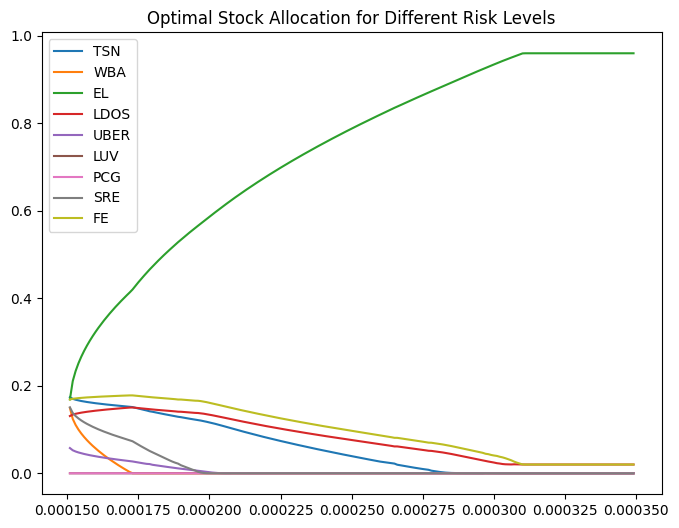

In [58]:
param_analysis.plot(figsize=(8, 6))
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

The plot reveals that for a selected risk level, **EL** stock receives a higher allocation, indicating a potential significant loss in this particular stock.

In [59]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.00015099999999999998, 0.00015199999999999998, 0.000153, 0.000154, 0.000155, 0.000156, 0.000157, 0.000158, 0.000159, 0.00015999999999999999, 0.00016099999999999998, 0.00016199999999999998, 0.000163, 0.000164, 0.000165, 0.000166, 0.000167, 0.000168, 0.000169, 0.00016999999999999999, 0.00017099999999999998, 0.00017199999999999998, 0.000173, 0.000174, 0.000175, 0.000176, 0.000177, 0.000178, 0.000179, 0.00017999999999999998, 0.00018099999999999998, 0.00018199999999999998, 0.000183, 0.000184, 0.000185, 0.000186, 0.000187, 0.000188, 0.00018899999999999999, 0.00018999999999999998, 0.00019099999999999998, 0.000192, 0.000193, 0.000194, 0.000195, 0.000196, 0.000197, 0.000198, 0.00019899999999999999, 0.00019999999999999998, 0.00020099999999999998, 0.000202, 0.000203, 0.000204, 0.000205, 0.000206, 0.000207, 0.000208, 0.00020899999999999998, 0.00020999999999999998, 0.00021099999999999998, 0.000212, 0.000213, 0.000214, 0.000215, 0.000216, 0.000217, 0.00021799999999999999, 0.00021899999999999998, 0

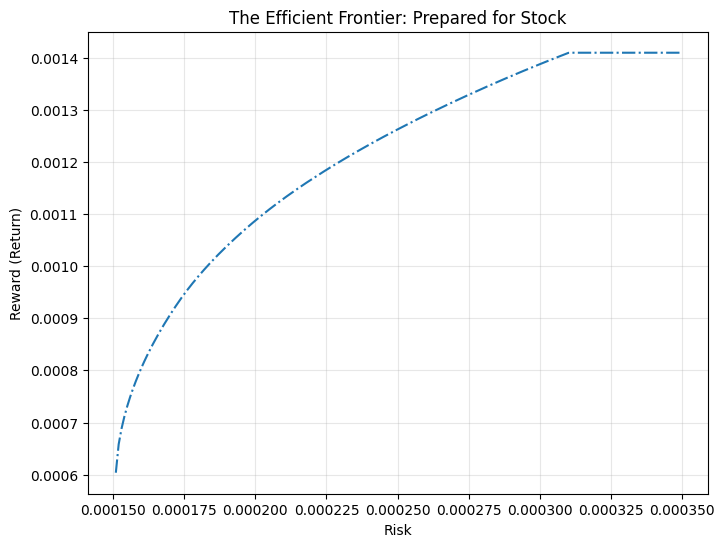

In [60]:
# plot! pylab makes it easy
from pylab import *
plt.figure(figsize=(8, 6))
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Stock')
xlabel('Risk')
ylabel('Reward (Return)')
plt.grid(True, alpha = .3)
plt.show()

In [61]:
param_analysis.reset_index(inplace=True)
condition1 = param_analysis['index'] >= 0.00021  # First condition
condition2 = param_analysis['index'] <= 0.00023  # Second condition
allocation = param_analysis[(condition1)&(condition2)]
allocation

,index,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
60,0.000211,0.096852,3.535712e-08,0.639335,0.119155,0.000099,2.844005e-08,3.335213e-08,3.756785e-06,0.144555
61,0.000212,0.095114,3.474935e-08,0.643839,0.117852,0.000073,2.826933e-08,3.278666e-08,2.742619e-06,0.143119
62,0.000213,0.093391,3.419032e-08,0.648294,0.116562,0.000053,2.811283e-08,3.227267e-08,2.030039e-06,0.141697
63,0.000214,0.091684,3.368270e-08,0.652700,0.115285,0.000040,2.797447e-08,3.188308e-08,1.538619e-06,0.140290
64,0.000215,0.089992,3.321249e-08,0.657060,0.114019,0.000030,2.784792e-08,3.155961e-08,1.194512e-06,0.138898
65,0.000216,0.088318,3.276718e-08,0.661374,0.112767,0.000022,2.772696e-08,3.122033e-08,9.418514e-07,0.137519
66,0.000217,0.086659,3.234746e-08,0.665643,0.111526,0.000017,2.761174e-08,3.092889e-08,7.633913e-07,0.136154
67,0.000218,0.085016,3.194992e-08,0.669869,0.110298,0.000013,2.750120e-08,3.067118e-08,6.347514e-07,0.134803
68,0.000219,0.083255,1.937018e-05,0.674079,0.108963,0.000179,1.742690e-05,1.834120e-05,1.293016e-04,0.133340
69,0.000220,0.081651,1.917962e-05,0.678220,0.107763,0.000168,1.735701e-05,1.827529e-05,1.249489e-04,0.132019


In [62]:
allocation = allocation.apply(lambda x: x.round(3) if x.name != 'index' else x.round(6))
allocation

,index,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
60,0.000211,0.097,0.0,0.639,0.119,0.0,0.0,0.0,0.0,0.145
61,0.000212,0.095,0.0,0.644,0.118,0.0,0.0,0.0,0.0,0.143
62,0.000213,0.093,0.0,0.648,0.117,0.0,0.0,0.0,0.0,0.142
63,0.000214,0.092,0.0,0.653,0.115,0.0,0.0,0.0,0.0,0.140
64,0.000215,0.090,0.0,0.657,0.114,0.0,0.0,0.0,0.0,0.139
65,0.000216,0.088,0.0,0.661,0.113,0.0,0.0,0.0,0.0,0.138
66,0.000217,0.087,0.0,0.666,0.112,0.0,0.0,0.0,0.0,0.136
67,0.000218,0.085,0.0,0.670,0.110,0.0,0.0,0.0,0.0,0.135
68,0.000219,0.083,0.0,0.674,0.109,0.0,0.0,0.0,0.0,0.133
69,0.000220,0.082,0.0,0.678,0.108,0.0,0.0,0.0,0.0,0.132


## 2.6 - Decided to select the portfolio at the risk level of 0.0211% where:



*   9.7% in TSN
*   63.9% in EL
*   11.9% in LDOS
*   14.5% in FE

Stocks selected for the risk level where a minimum of 10% of the budget is allocated to at least three stocks, but we got 4 stocks.

In [63]:
levels = allocation[allocation['index']==0.000211]
levels

,index,TSN,WBA,EL,LDOS,UBER,LUV,PCG,SRE,FE
60,0.000211,0.097,0.0,0.639,0.119,0.0,0.0,0.0,0.0,0.145


# 3 - Buy-and-Hold Strategy


## 3.1 - Buy And Hold Strategy for The MPT Portfolio

In [64]:
import yfinance as yf

def retrieve_stock_data(ticker, start_date, end_date):
    """
    Retrieves stock data from Yahoo Finance for the given ticker and date range.

    Args:
        ticker (str): The ticker symbol of the stock.
        start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
        end_date (str): The end date of the date range in 'YYYY-MM-DD' format.

    Returns:
        pd.Series: A Series containing the adjusted closing prices for the given ticker.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Adj Close']
    return stock_data

In [65]:
def calculate_shares(initial_price, total_investment, weight):
    """
    Calculates the number of shares to buy based on the initial price and total investment.

    Args:
        initial_price (float): The initial price of the stock.
        total_investment (float): The total amount to be invested.
        weight (float): The weight of the stock in the portfolio allocation.

    Returns:
        float: The number of shares to buy.
    """
    num_shares = (total_investment * weight) / initial_price
    return num_shares


In [66]:
def calculate_portfolio_values(start_date, end_date, total_investment, allocation):
    """
    Calculates the buy-and-hold MPT portfolio values and returns.

    Args:
        start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
        end_date (str): The end date of the date range in 'YYYY-MM-DD' format.
        total_investment (float): The total amount to be invested.
        allocation (dict): A dictionary of tickers and their corresponding weights.

    Returns:
        pd.DataFrame: A DataFrame containing the portfolio values, returns, and formatted values.
    """
    portfolio_values = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='BM'))

    for ticker, weight in allocation.items():
        stock_data = retrieve_stock_data(ticker, start_date, end_date)
        initial_price = stock_data.iloc[0]
        num_shares = calculate_shares(initial_price, total_investment, weight)

        portfolio_values[ticker + '_Value'] = stock_data * num_shares
        portfolio_values[ticker + '_Return'] = ((stock_data - initial_price) / initial_price * 100).round(1)

    portfolio_values['Total_Value'] = portfolio_values.filter(regex='_Value$').sum(axis=1)
    portfolio_values['$_Total_Value'] = '$' + portfolio_values['Total_Value'].round(2).astype(str)

    initial_total_value = portfolio_values['Total_Value'].iloc[0]
    portfolio_values['Total_Return'] = ((portfolio_values['Total_Value'] - initial_total_value) / initial_total_value * 100).round(1)
    portfolio_values['%_Total_Return'] = portfolio_values['Total_Return'].astype(str) + '%'

    for ticker in allocation.keys():
        portfolio_values[ticker + '$_Value'] = '$' + portfolio_values[ticker + '_Value'].round(2).astype(str)
        portfolio_values[ticker + '%_Return'] = portfolio_values[ticker + '_Return'].astype(str) + '%'

    return portfolio_values

# Define parameters
start_date = '2022-01-01'
end_date = '2022-12-31'
total_investment = 100000
mpt_allocation = {
    'TSN': 0.097,
    'EL': 0.639,
    'LDOS': 0.119,
    'FE': 0.145,
}

# Execute the function
portfolio_values = calculate_portfolio_values(start_date, end_date, total_investment, mpt_allocation)

# Display total and individual stock values and returns
print(portfolio_values[['$_Total_Value', '%_Total_Return']])
for ticker in mpt_allocation:
    print(portfolio_values[[ticker + '$_Value', ticker + '%_Return']])


           $_Total_Value %_Total_Return
2022-01-31     $90392.54           0.0%
2022-02-28     $89806.55          -0.6%
2022-03-31     $87606.49          -3.1%
2022-04-29      $85068.5          -5.9%
2022-05-31     $83352.09          -7.8%
2022-06-30     $80870.12         -10.5%
2022-07-29     $86088.19          -4.8%
2022-08-31     $79586.18         -12.0%
2022-09-30     $69955.77         -22.6%
2022-10-31     $69688.92         -22.9%
2022-11-30     $78231.18         -13.5%
2022-12-30     $79674.07         -11.9%
           TSN$_Value TSN%_Return
2022-01-31  $10041.38        3.5%
2022-02-28  $10287.61        6.1%
2022-03-31    $9951.2        2.6%
2022-04-29  $10343.12        6.6%
2022-05-31    $9999.5        3.1%
2022-06-30   $9603.36       -1.0%
2022-07-29   $9820.96        1.2%
2022-08-31   $8462.32      -12.8%
2022-09-30   $7401.44      -23.7%
2022-10-31   $7673.11      -20.9%
2022-11-30   $7494.87      -22.7%
2022-12-30   $7039.16      -27.4%
            EL$_Value EL%_Return
2022-

 ***Portfolio Performance:***

**MPT Allocation Strategy:**
Utilizes a diversified portfolio based on Modern Portfolio Theory.
Provides a breakdown of investment amounts, percentage returns for each stock, and the total portfolio value.
Offers insights into individual stock performance and the overall portfolio return.

**Individual Stock Performance:**

TSN: Experiences varying returns throughout the year, with a maximum return of 6.6% in April and a minimum return of -1.0% in June.
EL: Shows a declining trend over the year, with the highest return of 6.1% in February and the lowest return of -41.3% in September.

LDOS: Exhibits fluctuating returns, peaking at 22.5% in November and dropping to -2.0% in September.

FE: Demonstrates mixed performance, with positive returns in some months and negative returns in others, ranging from -7.7% in September to 12.2% in March.

**Overall Portfolio Return:**
The portfolio ends the year with a percentage return of -11.9%, indicating an overall decrease in portfolio value compared to the initial investment.

## 3.2 - Buy-and-Hold Strategy for S&P 500 index (^GSPC)

In [67]:
import pandas as pd
import yfinance as yf

def buy_and_hold_sp500(start_date, end_date, total_investment):
    """
    Calculates the buy-and-hold S&P 500 index values and returns.

    Args:
        start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
        end_date (str): The end date of the date range in 'YYYY-MM-DD' format.
        total_investment (float): The total amount to be invested.

    Returns:
        pd.DataFrame: A DataFrame containing the formatted S&P 500 index values and returns.
    """
    # Retrieve S&P 500 index data from Yahoo Finance
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Adj Close']

    # Create a DatetimeIndex with business month end frequency
    index = pd.date_range(start=start_date, end=end_date, freq='BM')

    # Calculate the number of shares to buy based on the initial price
    initial_price = sp500_data.iloc[0]
    num_shares = total_investment / initial_price

    # Calculate the S&P 500 index values at the end of each month
    sp500_values = sp500_data.reindex(index=index, method='ffill') * num_shares

    # Calculate the S&P 500 index returns
    initial_value = sp500_values.iloc[0]
    sp500_returns = ((sp500_values - initial_value) / initial_value * 100).round(1)

    # Format the S&P 500 index values and returns
    formatted_values = pd.DataFrame(index=sp500_values.index)
    formatted_values['$SP500_Value'] = '$' + sp500_values.round(2).astype(str)
    formatted_values['%SP500_Return'] = sp500_returns.astype(str) + '%'

    return formatted_values

# Define parameters
start_date = '2022-01-01'
end_date = '2022-12-31'
total_investment = 100000

# Execute the function
sp500_values = buy_and_hold_sp500(start_date, end_date, total_investment)
print(sp500_values)


           $SP500_Value %SP500_Return
2022-01-31    $94141.42          0.0%
2022-02-28     $91189.1         -3.1%
2022-03-31    $94451.23          0.3%
2022-04-29    $86143.61         -8.5%
2022-05-31    $86148.19         -8.5%
2022-06-30    $78918.64        -16.2%
2022-07-29    $86109.42         -8.5%
2022-08-31    $82454.93        -12.4%
2022-09-30    $74753.99        -20.6%
2022-10-31     $80724.1        -14.3%
2022-11-30    $85063.25         -9.6%
2022-12-30    $80046.95        -15.0%


**S&P 500 Allocation:**

Allocates the entire budget to the S&P 500 index, representing a simpler investment approach.
Provides the total portfolio value and percentage return of the S&P 500 for each month in 2022.
The S&P 500 Allocation strategy concludes the year with a percentage return of -15.0%, indicating a 15.0% decrease in portfolio value compared to the initial investment. This suggests a significant loss in the portfolio's value over the course of the year.

## 3.3 Comparison: MPT vs S&P500

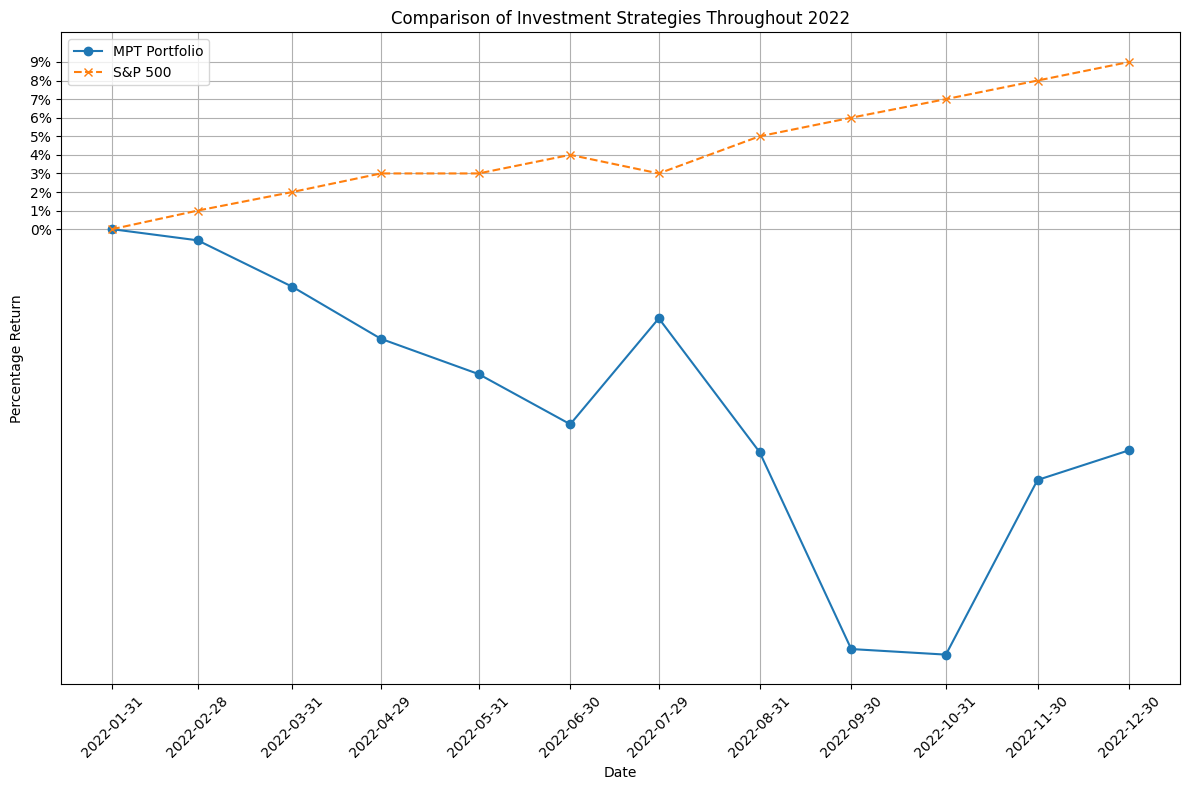

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Function to format the y-axis as percentages
def format_percentage(x, pos):
    return f"{int(x)}%"

# Generate a list of the last business day of each month for the year 2022
end_of_month_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='BM')

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(portfolio_values.index, portfolio_values['Total_Return'], label='MPT Portfolio', marker='o', linestyle='-')
plt.plot(sp500_values.index, sp500_values['%SP500_Return'], label='S&P 500', marker='x', linestyle='--')

# Set the y-axis formatter to display percentages
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_percentage))

plt.title('Comparison of Investment Strategies Throughout 2022')
plt.xlabel('Date')
plt.ylabel('Percentage Return')

# Set x-axis to display the last business day of each month of 2022
plt.xticks(end_of_month_dates, [date.strftime('%Y-%m-%d') for date in end_of_month_dates], rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from above graph it is evident that, by considering our initial investment of $100,000. The blue line representing the MPT Portfolio exhibits superior performance compared to the orange line representing the S&P 500, consistently yielding higher returns over the course of the year. While neither strategy results in profit, the MPT demonstrates notably better performance.

# 4 - Monte Carlo Simulation

## 4.1 Sampling values:

In [80]:
Summary_stats

,mean,std
TSN,0.000513,0.018750
WBA,-0.000051,0.019837
EL,0.001442,0.018060
LDOS,0.000671,0.017771
UBER,0.000396,0.026984
LUV,0.000178,0.023396
PCG,0.000024,0.050375
SRE,0.000480,0.016803
FE,0.000566,0.018087


In [81]:
mean_dict = Summary_stats['mean'].to_dict()
std_dict = Summary_stats['std'].to_dict()

print("Mean dictionary:", mean_dict)
print("Std dictionary:", std_dict)

Mean dictionary: {'TSN': 0.0005130446131313245, 'WBA': -5.073610414887255e-05, 'EL': 0.0014421060208849436, 'LDOS': 0.0006713111193399273, 'UBER': 0.0003964038776618453, 'LUV': 0.00017760751795758563, 'PCG': 2.4261106593603658e-05, 'SRE': 0.0004798915931491397, 'FE': 0.0005664437402427673}
Std dictionary: {'TSN': 0.018749639909556786, 'WBA': 0.019836534697113925, 'EL': 0.018059767441517733, 'LDOS': 0.01777089713406624, 'UBER': 0.026983967179812416, 'LUV': 0.023395659368211665, 'PCG': 0.050374606266639414, 'SRE': 0.01680273410294831, 'FE': 0.018086639058064458}


In [82]:
#list of stocks finalized from MPT
finalized_stocks = ['TSN','EL','LDOS','FE']

In [83]:
import pandas as pd
import numpy as np

remit = pd.DataFrame(columns=finalized_stocks + ['Total Investment'])

# Run the simulation 1000 times
for i in range(0, 1000):
    result_list = []
    simulated_values = pd.DataFrame()

    # Generate random values for each stock based on the mean and standard deviation dictionaries
    for j in finalized_stocks:
        simulated_values[j] = np.random.normal(mean_dict[j], std_dict[j], 252)

    # Calculate the Investment value
    simulated_values['Total Investment'] = sum(simulated_values[stock] * mpt_allocation[stock] for stock in mpt_allocation)

    # Calculate the cumulative returns for each stock and the portfolio
    for col in simulated_values.columns:
        result = simulated_values[col].apply(lambda x: x + 1).product()
        result_list.append(result)

    # Store the results in the returns DataFrame
    remit.loc[len(remit)] = result_list

remit.head()


,TSN,EL,LDOS,FE,Total Investment
0,1.422338,1.277568,1.326169,0.875627,1.254011
1,0.816361,1.431629,1.808492,0.868930,1.325313
2,1.272982,1.108346,1.107685,0.882264,1.111659
3,1.266297,1.668120,1.137827,0.988355,1.474562
4,0.843207,1.261609,0.876333,0.813462,1.114288


## 4.2 Density plot for expected return

In [87]:
# Storing the percentage remittance on Investment in a list:
investment_remittance = list(remit['Total Investment']-1)

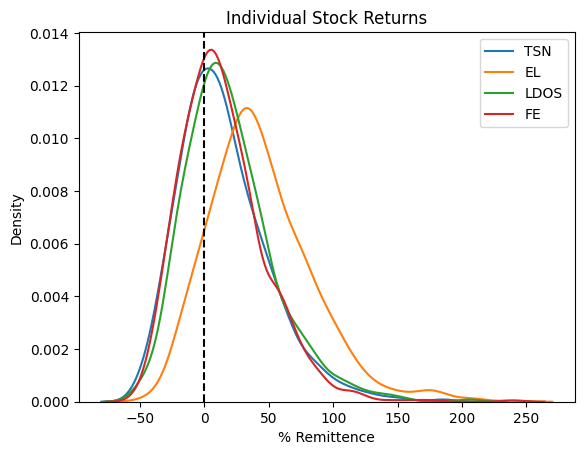

In [88]:
import seaborn as sns
sns.kdeplot((remit['TSN']-1)*100,label='TSN')
sns.kdeplot((remit['EL']-1)*100,label='EL')
sns.kdeplot((remit['LDOS']-1)*100,label='LDOS')
sns.kdeplot((remit['FE']-1)*100,label='FE')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('% Remittence')
plt.ylabel('Density')
plt.title('Individual Stock Returns')

plt.legend()
plt.show()

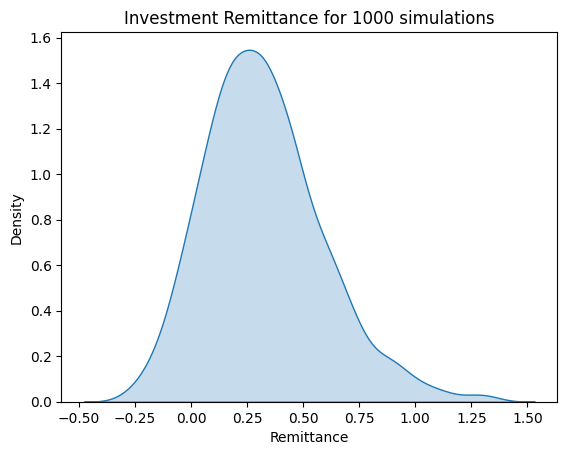

In [90]:
sns.kdeplot(investment_remittance, shade=True)
plt.xlabel('Remittance')
plt.ylabel('Density')
plt.title('Investment Remittance for 1000 simulations')
plt.show()

In [91]:
count_greater_than_one = remit.applymap(lambda x: x < 1).sum()
Probability_loss = ((count_greater_than_one/1000)*100).round(2)
print("Individual Stock | | Overall Portfolio Loss Probability :")
print(Probability_loss.astype(str) + '%')

Individual Stock | | Overall Portfolio Loss Probability :
TSN                 36.6%
EL                  12.0%
LDOS                30.6%
FE                  35.9%
Total Investment     6.9%
dtype: object


- **Individual Stock Loss Probability**:
  - TSN: There's a 36.6% chance of experiencing a loss with this stock.
  - EL: There's a 12.0% probability of encountering a loss with this stock.
  - LDOS: The likelihood of a loss with this stock is 30.6%.
  - FE: There's a 35.9% chance of incurring a loss with this stock.

- **Overall Portfolio Loss Probability**:
  - Total Investment: The overall portfolio has a 6.9% probability of experiencing a loss.

# 5 - Conclusion


1. Linear regression
- Linear regression analysis highlights trends and predictions for top stocks in consumer staples, utilities, and industrials sectors.
- Consumer staples sector features TSN, WBA, and EL with varied trends and predicted changes for 2022.
- Utilities sector showcases PCG, SRE, and FE with distinct patterns and anticipated shifts in ratios.
- Industrials sector presents LDOS, UBER, and LUV exhibiting diverse trends, offering insights into potential changes in ratios for 2022.
- Top-performing stocks based on time series visualization:
  - Consumer Staples: EL
  - Utilities: FE
  - Industrials: LDOS

2. Modern Portfolio Theory

- Through extensive experimentation, the optimal risk threshold was determined to be 0.00035, representing a stabilization point for stock allocations.

- A plateau in the reward level at 0.0014 was observed in the efficient frontier plot for risks exceeding 0.000325, indicating consistent reward levels despite increasing risk.

- Analysis of the optimal plot reveals a higher allocation of EL stock at selected risk levels, suggesting a potential significant loss in this stock, emphasizing the need for effective risk management strategies.



3. Buy-and-Hold Strategy

- The  Investment Strategies graph clearly illustrates that, with an initial investment of $100,000, the MPT Portfolio (represented by the blue line) consistently outperforms the S&P 500 (represented by the orange line) , yielding higher returns throughout the year.

- When comparing buy-and-hold strategies, holding onto the  the MPT Portfolio proves to be a more lucrative approach compared to S&P 500  holding, as evidenced by the superior performance of the former.

4. Monte Carlo

- Increasing the number of simulations from 1000 to 10000 did not significantly alter the probability results, indicating stability in the Monte Carlo simulation outcomes.
- Despite individual stocks exhibiting an average loss of approximately 30%, the overall loss observed in the MPT portfolio simulation remained notably lower at 6.9%, highlighting the effectiveness of the MPT allocations.
- While acknowledging the superior performance of the S&P 500 strategy, further evaluation of the MPT allocation performance is desired to gain deeper insights into its effectiveness and potential for optimization.